# import

In [1]:
from utlis import TurboState,update_state,get_initial_points
import torch

In [2]:
import os
import math
from dataclasses import dataclass

import numpy as np
import GPy
import matplotlib.pyplot as plt
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine
from gpytorch.kernels import MaternKernel, RBFKernel, IndexKernel
from botorch.models import FixedNoiseGP, ModelListGP
from botorch.utils.transforms import normalize,unnormalize

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior
from botorch.models import FixedNoiseGP, ModelListGP

from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

from botorch.utils.transforms import standardize
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior

import warnings


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder
from botorch.test_functions import Hartmann
from botorch.test_functions import Griewank

# setting

In [4]:
fun = Ackley(dim=2,negate=True)
dim = fun.dim
# lb = torch.tensor([0])
# ub = torch.tensor([1])
bounds = fun.bounds

batch_size = 1
n_init = 5 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

NUM_RESTARTS = 4*dim 
RAW_SAMPLES = 100*dim 

exp_num = 20
iter_num = 15*dim

# Normal BO

In [5]:
BO_res = []

for N in range(exp_num):
    
    print(N)
    
    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)
    
    best = Y_BO.max()
    best_record = [best]
    

    for i in range(iter_num):  # Run until TuRBO converges
        # Fit a GP model
        train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
        
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        covar_module = ScaleKernel(MaternKernel())
        model = FixedNoiseGP(train_X, train_Y,train_yvar.expand_as(train_Y), covar_module=covar_module)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        fit_gpytorch_mll(mll)

        # Create a batch
        EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)   
        X_next_normalized, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,  
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={},
        )
        
        X_next = unnormalize(X_next_normalized, bounds)
        

        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)
        
        best_record.append(Y_BO.max())
        
    BO_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Non-stationary Kernel

In [6]:
class NonStationaryMaternKernel(gpytorch.kernels.MaternKernel):
    def __init__(self, input_dim, nu=2.5):
        super().__init__(nu=nu, ard_num_dims=input_dim)

        # create a linear mean function to model the lengthscale
        self.mean_module = gpytorch.means.LinearMean(input_dim)

    def forward(self, x1, x2, **params):
        # get the lengthscale from the mean module
        lengthscale = self.mean_module(x1)

        # pass the lengthscale to the Matern kernel
        return super().forward(x1, x2, lengthscale=lengthscale, **params)

In [8]:
Kernel_res = []

for N in range(exp_num):
    
    print(N)
    
    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)
    
    best = Y_BO.max()
    best_record = [best]
    

    for i in range(iter_num):  # Run until TuRBO converges
        # Fit a GP model
        train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
        
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        covar_module = ScaleKernel(NonStationaryMaternKernel(input_dim=dim))
        model = FixedNoiseGP(train_X, train_Y,train_yvar.expand_as(train_Y), covar_module=covar_module)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        fit_gpytorch_mll(mll)

        # Create a batch
        EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)   
        X_next_normalized, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,  
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={},
        )
        
        X_next = unnormalize(X_next_normalized, bounds)
        

        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)
        
        best_record.append(Y_BO.max())
        
    Kernel_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Treed BO

In [9]:
import sys
sys.path.append('/home/hanyang/Documents/Treed BO')
from treed_gp import partitation,gp_leaf_llk

In [10]:
min_leaf_num = 2*dim+1

In [11]:
Treed_res = []

for N in range(exp_num):

  print(N)
  
  seed = N
  X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
  Y_BO = torch.tensor(
      [fun(x) for x in X_BO], dtype=dtype, device=device
  ).reshape(-1,1)


  torch.manual_seed(seed)
  
  best = Y_BO.max()
  best_record = [best]

  standard_bounds = torch.tensor([0.,1.]*dim).reshape(-1,2) 
  for j in range (iter_num):

    choice = [] 
    acq_val = [] 
    
    train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
    train_X = normalize(X_BO, bounds)
    
    best_standard = train_Y.max()

    train_X = train_X.numpy()
    train_Y = train_Y.numpy()

    my_tree = partitation.tree_partation(train_X,train_Y,standard_bounds.tolist(),5,min_leaf_num)  
    my_tree.return_path([0], ['no'])

    leaf_nodes = my_tree.leaf_nodes

    for leaf in leaf_nodes:
      leaf_gp_temp = gp_leaf_llk.leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)

      covar_module = ScaleKernel(MaternKernel())
      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp),covar_module=covar_module).to(device)
      mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

      try:
        fit_gpytorch_mll(mll) 
      except:
        pass

      #find the next evaluation
      EI = ExpectedImprovement(model=model, best_f=best_standard) .to(device)  

      new_point_analytic, val = optimize_acqf(
          acq_function=EI,
          bounds=torch.tensor(boundary_temp,device=device, dtype=dtype).T,  
          q=batch_size,
          num_restarts=NUM_RESTARTS,
          raw_samples=RAW_SAMPLES,
          options={},
      ) 


      choice.append(new_point_analytic)
      acq_val.append(val)


    idx = np.argmax(np.array(acq_val))
    X_next_normalized = choice[idx]
    X_next = unnormalize(X_next_normalized, bounds)

    Y_next = fun(X_next).reshape(-1,1)

    train_X = torch.tensor(train_X)
    train_Y = torch.tensor(train_Y)
    
    X_BO = torch.cat((X_BO, X_next))
    Y_BO = torch.cat((Y_BO, Y_next))
    
    best_record.append(Y_BO.max())


  Treed_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# TuRBO

In [12]:
TuRBO_res = []

for N in range(exp_num):
    
    print(N)
    
    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    state = TurboState(dim, batch_size=batch_size)


    torch.manual_seed(seed)
    
    best = Y_BO.max()
    best_record = [best]


    for i in range(iter_num):  # Run until TuRBO converges
        
        if not state.restart_triggered:
            # Fit a GP model
            train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            covar_module =     covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
            MaternKernel(
                nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
            )
            )
            model = FixedNoiseGP(train_X, train_Y,train_yvar.expand_as(train_Y), covar_module=covar_module)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)

            fit_gpytorch_mll(mll)
            
            #determine the searching area
            x_center = train_X[train_Y.argmax(), :].clone()
            weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
            weights = weights / weights.mean()
            weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
            tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
            tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

            # Create a batch
            EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)   
            X_next_normalized, _ = optimize_acqf(
                acq_function=EI,
                bounds=torch.stack([tr_lb, tr_ub]),         
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={},
            )
            
            X_next = unnormalize(X_next_normalized, bounds)
            Y_next = torch.tensor(
                [fun(x) for x in X_next], dtype=dtype, device=device
            ).reshape(-1,1)

            # Update state
            state = update_state(state=state, Y_next=Y_next)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(max(best_record[-1],Y_BO.max().item()))
            
        elif state.restart_triggered:
            
            state = TurboState(dim, batch_size=batch_size)
            
            initial_num = min(dim*2,iter_num-i)
            X_BO = get_initial_points(bounds, initial_num ,seed=seed+1234)
            Y_BO = torch.tensor(
                [fun(x) for x in X_BO], dtype=dtype, device=device
            ).reshape(-1,1)
            
            i = i + initial_num
            
            best_record.append(max(best_record[-1],Y_BO.max().item()))
            
        
    TuRBO_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Warping

In [13]:
Warp_res = []

for N in range(exp_num):
    
    print(N)
    
    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)
    
    best = Y_BO.max().item()
    best_record = [best]
    

    for i in range(iter_num):  # Run until TuRBO converges
        # Fit a GP model
        train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
        
        train_Y = standardize(Y_BO) #(Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        warp_tf = Warp(
        indices=list(range(train_X.shape[-1])),
        concentration1_prior=LogNormalPrior(0.0, 0.75**0.5),
        concentration0_prior=LogNormalPrior(0.0, 0.75**0.5),
        )
        
        covar_module = ScaleKernel(MaternKernel())
        model = FixedNoiseGP(
            train_X,
            train_Y,
            train_yvar.expand_as(train_Y),
            input_transform=warp_tf,
            covar_module=covar_module).to(train_X)
        
        
        # covar_module = ScaleKernel(MaternKernel())
        # model = FixedNoiseGP(train_X, train_Y,train_yvar.expand_as(train_Y), covar_module=covar_module)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        fit_gpytorch_mll(mll)

        # Create a batch
        EI = ExpectedImprovement(model=model, best_f=train_Y.max().item()) .to(device)   
        
        
        X_next_normalized, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([0.,1.]*dim,dtype=dtype, device=device).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,  # used for intialization heuristic
            options={},
                )
            
        X_next = unnormalize(X_next_normalized, bounds)
        

        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)
        
        best_record.append(Y_BO.max())
        
    Warp_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# ploting

Text(0.5, 1.0, 'Ackley 2D')

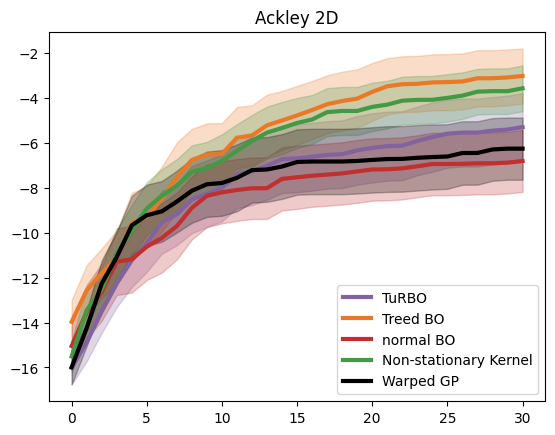

In [14]:
N = 20
total_record = np.array(TuRBO_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='TuRBO',color='#83639f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#83639f')

N = 20
total_record = np.array(Treed_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='Treed BO',color='#ea7827')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#ea7827')

total_record = np.array(BO_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='normal BO',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Kernel_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='Non-stationary Kernel',color='#449945')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#449945')

total_record = np.array(Warp_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='Warped GP',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.legend()
plt.title('Ackley 2D')

Text(0.5, 1.0, 'Branin 2D')

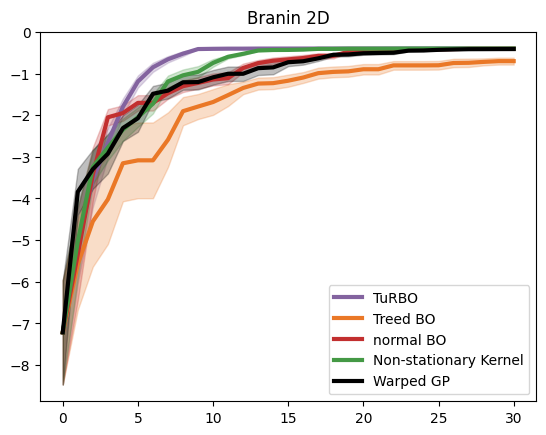

In [90]:
N = 20
total_record = np.array(TuRBO_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='TuRBO',color='#83639f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#83639f')

N = 20
total_record = np.array(Treed_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='Treed BO',color='#ea7827')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#ea7827')

total_record = np.array(BO_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='normal BO',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Kernel_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='Non-stationary Kernel',color='#449945')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#449945')

total_record = np.array(Warp_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='Warped GP',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.legend()
plt.title('Branin 2D')